# Structure Factor refinement of Si LARBED 111 systematic row

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyextal.dinfo import LARBEDDiffractionInfo
from pyextal.roi import LARBEDROI
from pyextal.optimize import CoarseOptimize, FineOptimize
from pyextal.gof import Chi2_LARBED
plt.rcParams['image.cmap'] = 'inferno'


pyextal package imported. Version: 0.0.1


## load Larbed data
1. load the image stack and flip the images
2. load the variance image and flip it
3. load the index for each image


In [2]:
dp = np.load("box/20250420/111sys area3/deconv3_ri4_Store_Larbed.npy")
dp = np.flip(dp,axis=2)
variance = np.load("box/20250420/111sys area3/deconv3_ri4_Store_LarbedVariance.npy")
variance = np.flip(variance,axis=2)
gindex = np.load("box/20250420/111sys area3/deconv3_ri4_g_vectors.npy")

# make sure no zero or negative values
dp[dp < 1] = 1

## initialize the diffraction info class  
- diffraction pattern
- estimate thickness
- additional tiltx and tilty
- estimate gl, g is deinfined in .dat file
- .dat file
- index of each image
- variance image

In [3]:
dinfo = LARBEDDiffractionInfo(dp,  600,  0, 0, 38.85, 'si110_111sys.dat', gindex, varianceMaps=variance)


## define parameter for region of interest:
- gx: g vector in the x direction
- rotation: relative to the xaxis set in .dat
- gInclude: include the g vector in the ROI



In [4]:
gx = np.array([1,-1,-1])
rotation = -112.07 - 33.7
gInclude = [(0,0,0),(1,-1,-1), (-1,1,1), (2,-2,-2), (-2,2,2), ]

In [5]:
roi = LARBEDROI(dinfo=dinfo, rotation=rotation, gx=gx, gInclude=gInclude) 



include beam initialized
group symmetry initialized


## select the region of interest

refer to ROI section in the documentation for details

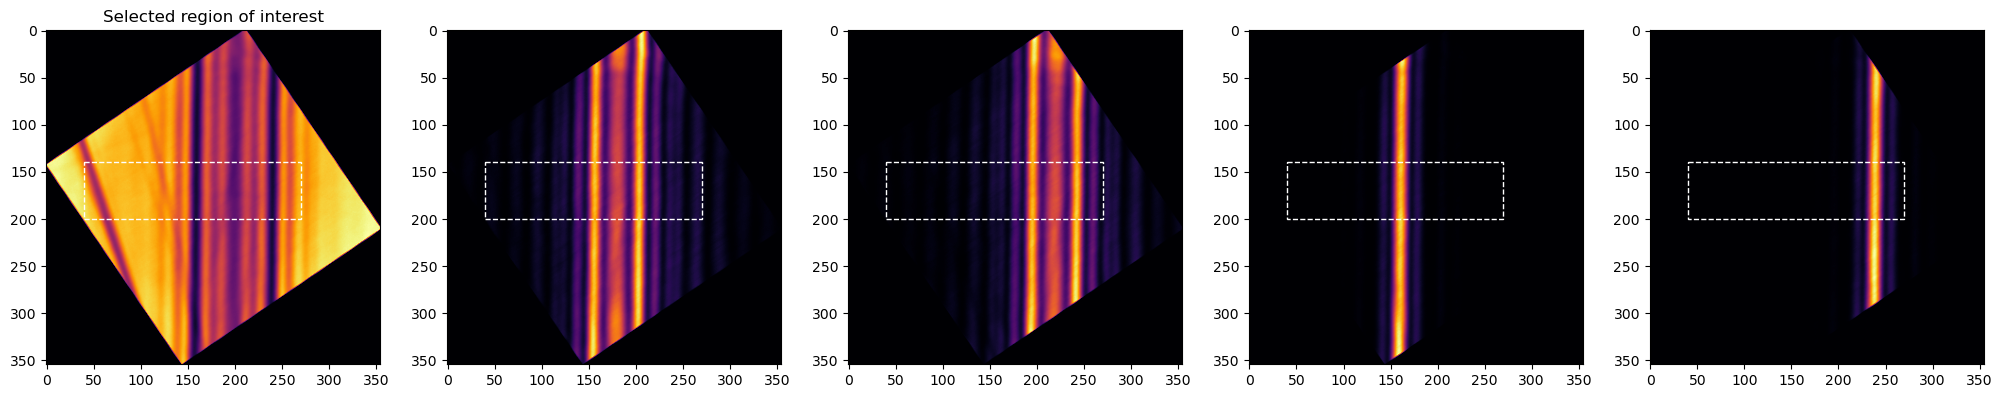

In [11]:
roi.selectROI(np.array([[[140,40], [140, 270], [200,40], [230,60]]]))
roi.displayROI()



## initialize coarse refinement

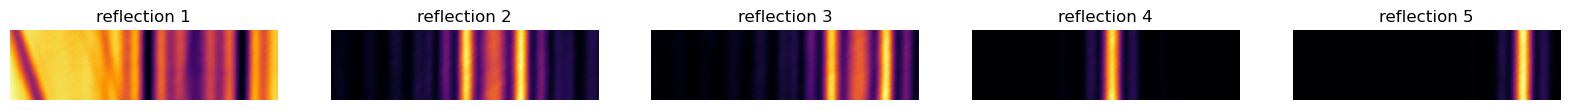

In [12]:
coarse = CoarseOptimize(dinfo=dinfo, roi=roi)

## refine orientation and thickness of the sample and display the results
IF THE COARSE SEARCH IS WAY OFF YOU NEED TO FIX TILT, ROTATION, OR ADJUST GL

In [13]:
coarse.optimizeOrientationThickness()


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 772.3219706436356, gl: 38.85, tiltY: -0.11031229284113353, tiltX: 0.19304651247198312


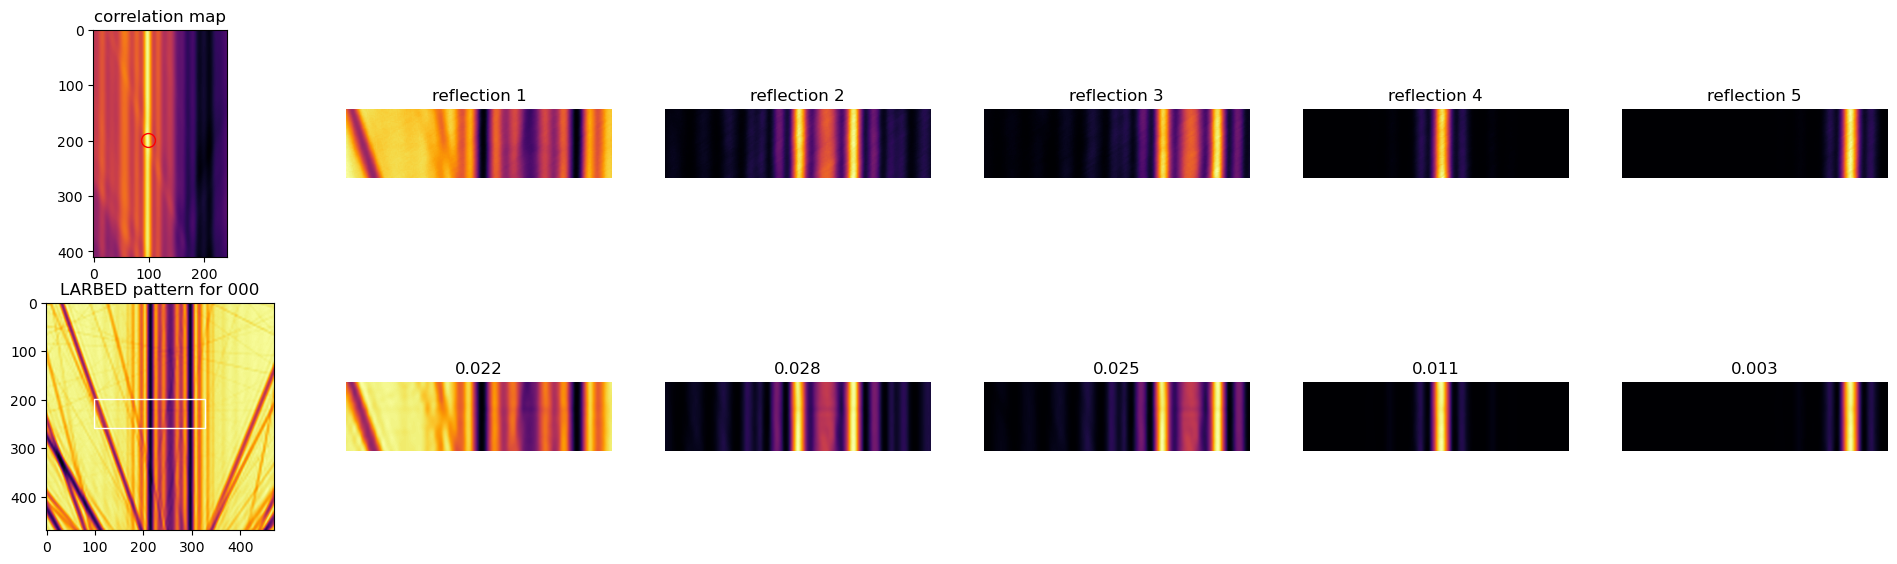

In [15]:
coarse.displayCoarseSearch()

## reselect the region of interest for fine refinement  
padding is needed when we refine LARBED and convolve the simulated pattern with a kernel. Padding is needed to avoid edge effects.


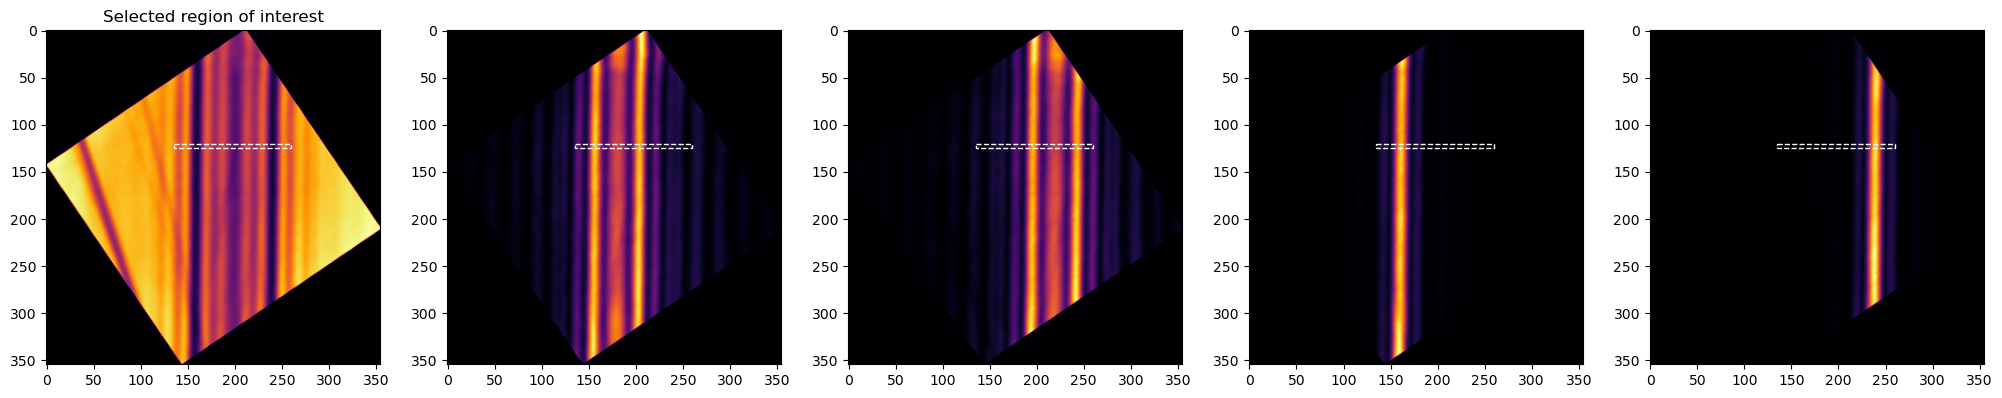

In [16]:


roi.selectROI(np.array([[[120,135], [120,260], [125, 135], [125,5]],                       
                        ]),padding=10
                        )


roi.displayROI()


## set parameters for fine refinement
- reflections: list of reflections to refine
- sfMask: mask for the structure factor refinement, sometimes absorption is omitted

In [17]:
reflection_list = [(-1,1,1), (2,-2,-2),]
sfMask = np.array([[True, True],[True, False]])

In [18]:
fine = FineOptimize(dinfo=dinfo,
                    roi=roi,
                    reflections=reflection_list,
                    sfMask=sfMask,
                    errorFunc=Chi2_LARBED(roi=roi),
                    perturbROI=True,
                    symUpdate=False,
                    probe=(1,1)
                   )

## set initial structure factor parameters
because 222 is fobidden in IAM model but allowed when bonding is considered, we need to manually set the initial structure factor parameters for 222 reflection  
if not given, IAM value will be used

In [ ]:
from pyextal.callBloch import lookupSF
init_val = lookupSF(reflection_list)
print("Initial values from lookupSF:", init_val)


Initial values from lookupSF: [[5.7493374e-02 0.0000000e+00 4.3672347e-04 1.8000000e+02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [ ]:
init_val[1][0] = -8e-4
init_val[1][1] = 180
init_val[1][2] = 0
init_val

array([[ 5.7493374e-02,  0.0000000e+00,  4.3672347e-04,  1.8000000e+02],
       [-7.9999998e-04,  1.8000000e+02,  0.0000000e+00,  0.0000000e+00]],
      dtype=float32)

the range for normalization also need to be set

In [23]:
init_valRange = np.array((init_val[:,::2]*0.95, init_val[:,::2]*1.05))

setting the initial value and normalization range to:
beam: (-1, 1, 1)
      lower       value       upper  
U : 5.4618705e-02   5.7493374e-02   6.0368039e-02
UA: 4.1488730e-04   4.3672347e-04   4.5855960e-04
------------------------------
beam: (2, -2, -2)
      lower       value       upper  
U : -7.5999997e-04   -7.9999998e-04   -8.3999994e-04
UA: 0.0000000e+00   0.0000000e+00   0.0000000e+00
------------------------------
(-1, 1, 1): U 0.0574934 UA 0.0004367
(2, -2, -2): U -0.0008000 UA 0.0000000
Chi Square single bacckground LARBED: 50.24594


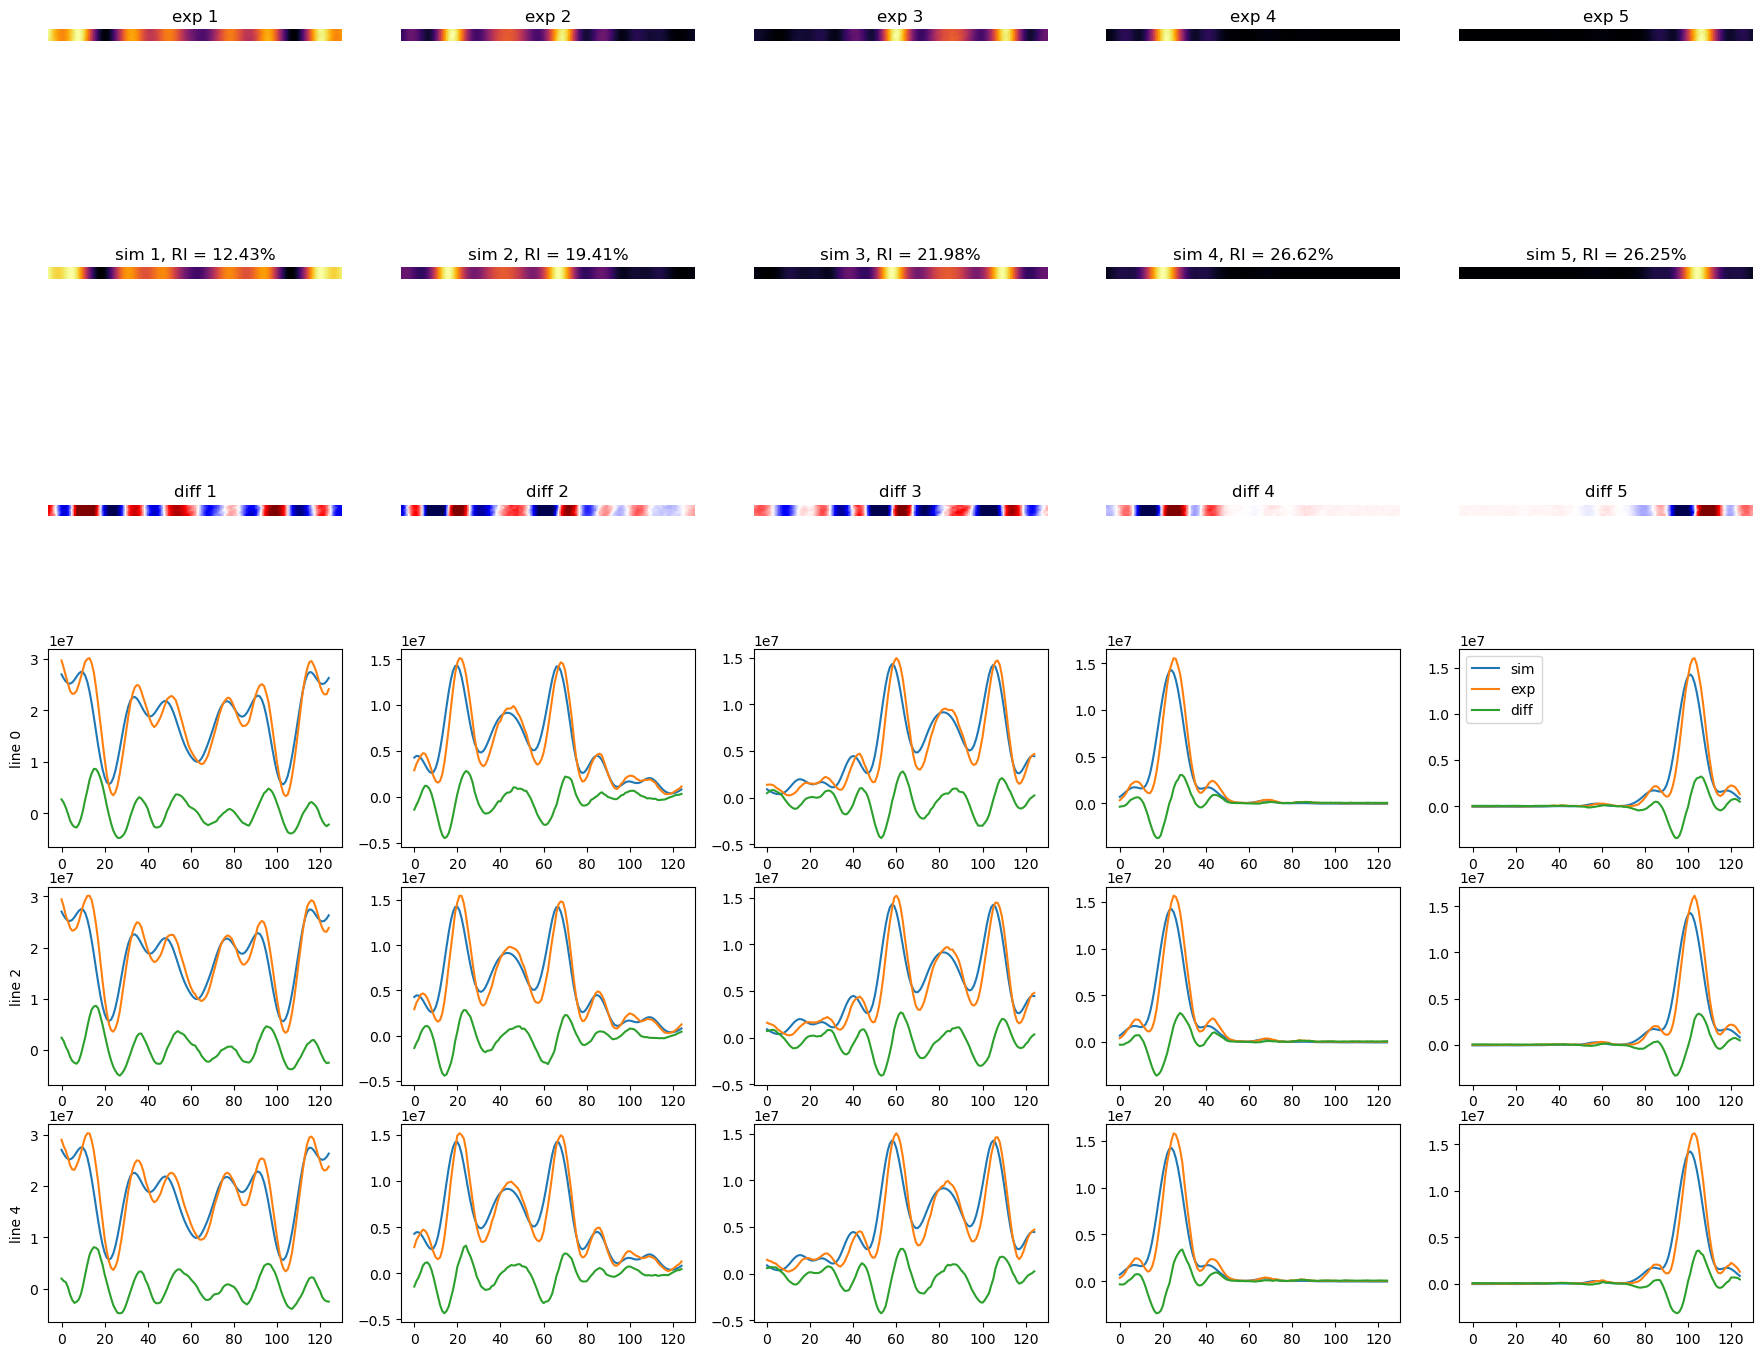

In [24]:
fine.getx0(init_val[:,::2])
fine.getRange(init_valRange)
fine.display([0,2,4,])

## perform fine refinement

In [25]:
%matplotlib qt


fine.optimize()


setting the initial value and normalization range to:
beam: (-1, 1, 1)
      lower       value       upper  
U : 5.4618705e-02   5.7493374e-02   6.0368039e-02
UA: 4.1488730e-04   4.3672347e-04   4.5855960e-04
------------------------------
beam: (2, -2, -2)
      lower       value       upper  
U : -7.5999997e-04   -7.9999998e-04   -8.3999994e-04
UA: 0.0000000e+00   0.0000000e+00   0.0000000e+00
------------------------------


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


start optimization
normal:[[ 0.05749337  0.00043672]
 [-0.0008      0.        ]]
SF:
(-1, 1, 1): 5.7493374e-02 4.3672347e-04
(2, -2, -2): -7.9999998e-04 0.0000000e+00


/home/hcni/project/bloch-python/src/pyextal/optimize.py:656: RuntimeWarning: invalid value encountered in divide
  return ((self.x0-self.x0Range[0])/(self.x0Range[1]-self.x0Range[0]))[self.sfMask]


thickness: 777.18 gl: 38.59843 rotation: -143.26058
corner: 1.62339 -3.28728
GOF: 4.37877  func eval: 1318
Error: 4.3675576158685505  func eval: 1318
********************
sigma: 1.708991700108378 gamma: 0.20379172514270874
SF:
(-1, 1, 1): 5.7637107e-02 4.3672347e-04
(2, -2, -2): -7.9999998e-04 0.0000000e+00
thickness: 775.93 gl: 38.58152 rotation: -143.20447
corner: 1.55701 -3.30729
GOF: 4.67713  func eval: 358
Error: 4.665159187407784  func eval: 358
********************
sigma: 1.1625928502561234 gamma: 0.28868738838986996
SF:
(-1, 1, 1): 5.7493374e-02 4.3781527e-04
(2, -2, -2): -7.9999998e-04 0.0000000e+00
thickness: 777.03 gl: 38.58171 rotation: -143.21680
corner: 1.54356 -3.30511
GOF: 4.34995  func eval: 117
Error: 4.338813927050003  func eval: 117
********************
sigma: 1.206411474361987 gamma: 0.2855450839645682
SF:
(-1, 1, 1): 5.7493374e-02 4.3672347e-04
(2, -2, -2): -8.0200000e-04 0.0000000e+00
thickness: 777.03 gl: 38.58162 rotation: -143.22254
corner: 1.53734 -3.30349
GO

In [45]:
roi.selectROI(np.array([[[90,70], [90,260], [180, 70], [190,90]]],))
                        

In [ ]:
roi.selectROI(np.array([[[140,40], [140, 270], [200,40], [230,60]]]))


In [41]:
roi.allshift

array([[-9.92503183,  3.51634284]])

(-1, 1, 1): U 0.0544844 UA 0.0006745
(2, -2, -2): U -0.0011552 UA 0.0000000
Chi Square single bacckground LARBED: 0.58550


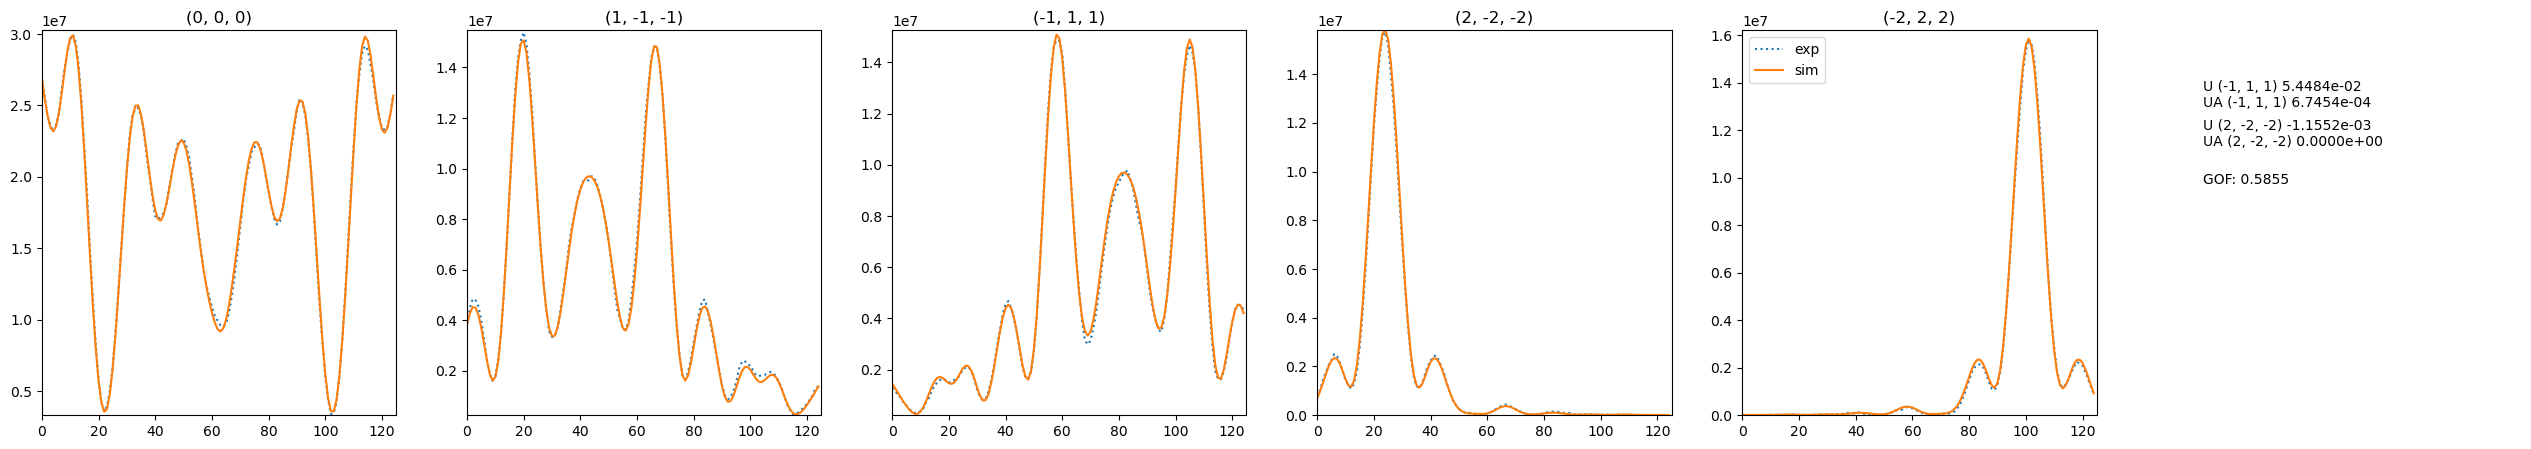

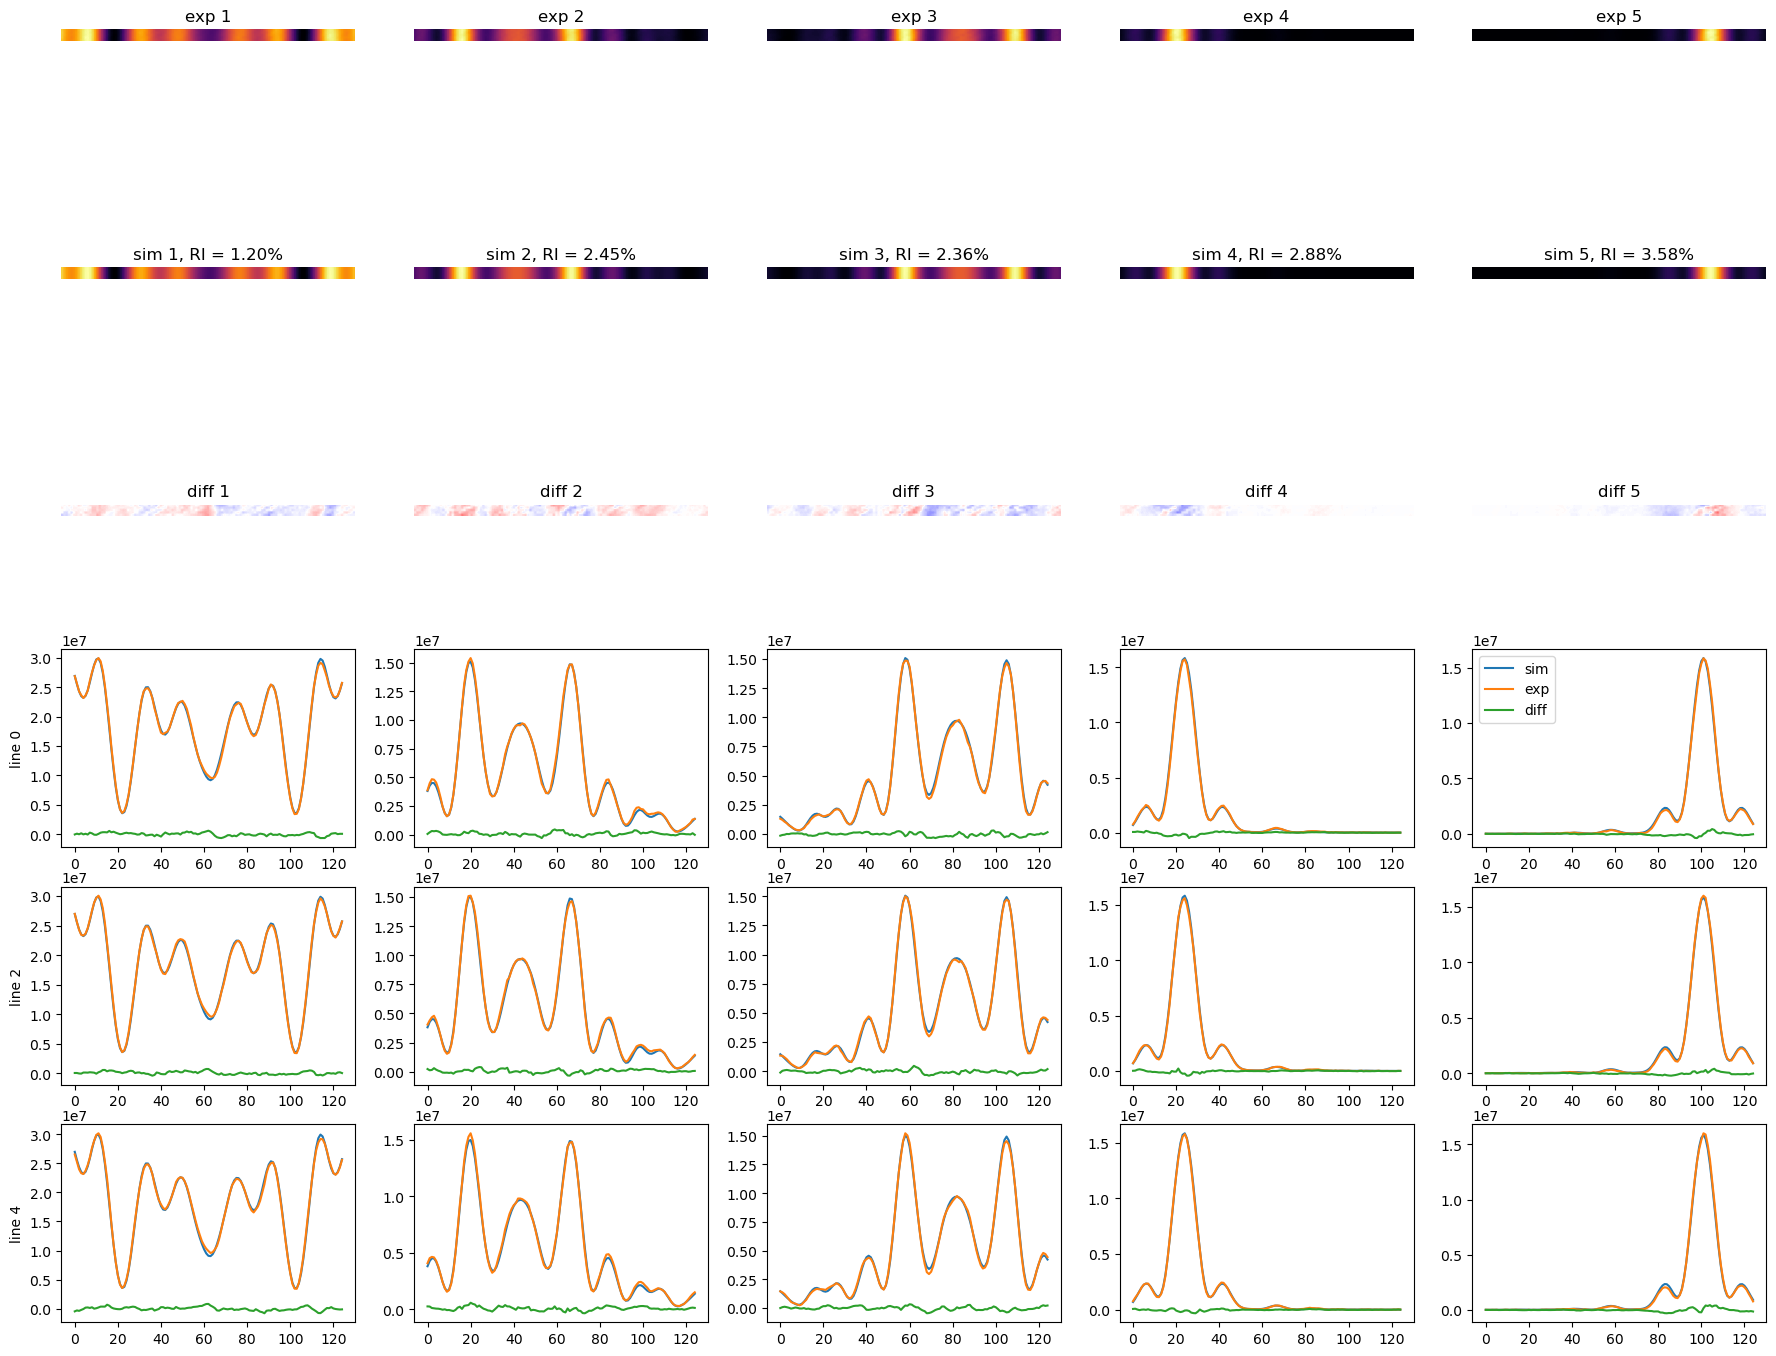

In [ ]:
%matplotlib inline

exp, sim = fine.display([0,2,4])

## display the kernel (probe shape in reciprocal space)

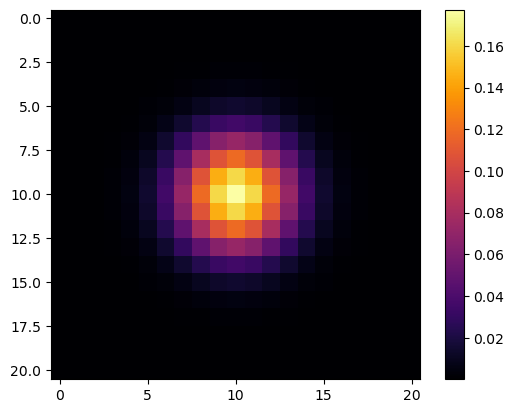

In [ ]:
from pyextal.optimize import voigt_2d
plt.imshow(voigt_2d(*fine.probe))
plt.colorbar()

## display the results

In [29]:

print(f'gl: {roi.gl} rotation: {roi.rotation}\n')
print(f'thickness: {fine.thickness}\n')
print(f'norm: {fine.errorFunc.scale}\n')
print(f'background: {fine.errorFunc.background}\n')

gl: 38.774782739075356 rotation: -145.50475891016094

thickness: 804.1431225760529

norm: 6154273.679528984

background: 3652.435141430087



In [34]:
from pyextal.callBloch import terminate
terminate()